In [1]:
import keras
import numpy as np
from keras.datasets import cifar10
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from skimage.transform import resize

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

Using TensorFlow backend.


1 Physical GPUs, 1 Logical GPUs


In [48]:
NUM_CLASSES = 10
BATCH_SIZE = 20
NUM_EPOCHS = 10


# LOAD CIFAR
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [64]:
# Instantiate the model 
# https://keras.io/api/applications/resnet/#resnet-and-resnetv2
# TODO : upscaling 32x32 
#        When setting `include_top=True` and loading `imagenet` weights, `input_shape` should be (224, 224, 3).

input_shape = (32, 32, 3)
classes = 10

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
#base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')


print(base_model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_18[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [65]:
# alternate method
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D

x = base_model.output
x = GlobalAveragePooling2D()(x)
model = Model(inputs = base_model.input, outputs = x)

#model = keras.Sequential(
#    [
#       base_model,
#        keras.layers.Flatten(),
#        keras.layers.Dense(1024, activation="relu"),
#        keras.layers.Dense(10, activation="softmax"),
#    ]
#)


In [ ]:
for idx in range(len(model.layers)):
    print(idx, model.get_layer(index = idx).__class__.__name__)
    


In [114]:
x = model.layers[7].output
x = GlobalAveragePooling2D()(x)
model_cut = Model(inputs = base_model.input, outputs = x)

In [116]:
#image = np.expand_dims(x_test[0], axis=0)
image = x_test[0:1000]
pred = model_cut.predict(image)

pred.shape

(1000, 64)

In [117]:
    
# Import PCA from sklearn
from sklearn.decomposition import PCA
import pandas as pd

# Instantiate PCA
pca = PCA(n_components=3)
X = pca.fit_transform(pred)

print(X.shape)
X = X[:,:2]  #just keep the two columns for visualization

# Create a new dataset from principal components 
df = pd.DataFrame(data = X, columns = ['PC1', 'PC2'])

target = pd.Series(np.array(y_test[0:1000]).flatten(), name='y')

result_df = pd.concat([df, target], axis=1)

result_df

(1000, 3)


PC1       PC2  y
0    0.001544 -0.006727  3
1   -0.014006  0.007507  8
2    0.002173  0.007797  8
3   -0.004487  0.012092  0
4    0.003476 -0.007729  6
..        ...       ... ..
995  0.000169 -0.002387  3
996  0.003401  0.004294  8
997 -0.013037 -0.010347  1
998  0.008234 -0.006186  3
999  0.010867  0.016862  8

[1000 rows x 3 columns]

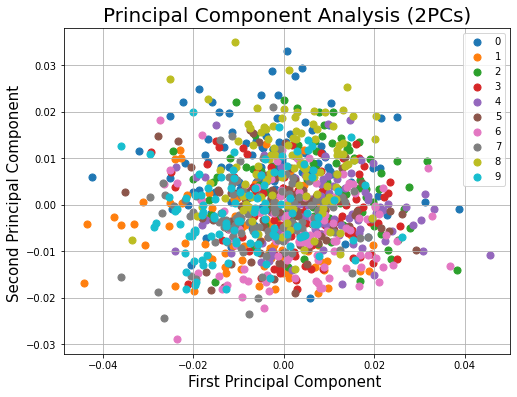

In [119]:
# Visualize Principal Components with a scatter plot
import matplotlib.pyplot as plt 

fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('First Principal Component ', fontsize = 15)
ax.set_ylabel('Second Principal Component ', fontsize = 15)
ax.set_title('Principal Component Analysis (2PCs)', fontsize = 20)

targets = np.unique(y_test)
#targets = [4,1]
colors = ["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf"]
#colors = ["#1f77b4","#ff7f0e"]
for target, color in zip(targets, colors):
    indicesToKeep = result_df.loc[result_df['y'] == target]
    ax.scatter(indicesToKeep['PC1'], 
               indicesToKeep['PC2'], 
               c = color, 
               s = 50)
ax.legend(targets)
ax.grid()
